In [4]:
import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [5]:
class DataGenerator:
    def __init__(
        self,
        target_normal_params = {'loc': 0, 'scale': 1},
        treatment_effect: float = 0.0,
        decay_factor: float = 1.0,
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.target_normal_params = target_normal_params
        self.treatment_effect = treatment_effect
        self.decay_factor = decay_factor
        
        self.total_panel = total_panel
        self.is_treatment_group = not control_group

        self.treatment_effects = np.array([treatment_effect*np.exp(-decay_factor*i) for i in range(total_panel)])
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        full_panel_data = np.clip(np.random.normal(size=(n_samples, self.total_panel), **self.target_normal_params), a_min=0, a_max=np.inf)
        full_panel_data = full_panel_data + self.treatment_effects
        unit_total = full_panel_data.sum(axis=1)
        surrogate_data = full_panel_data[:, :n_surrogates]
        data = (
            pd.DataFrame(
                data = np.hstack([surrogate_data, unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data
    
    def get_mean(self):
        return np.array(self.choice_probability) @ self.choices

In [6]:
def surrogate_index_model_experiment(
        n_surrogates:int = 4,
        train_normal_params = {'loc': 0, 'scale': 1},
        test_normal_params = {'loc': 0, 'scale': 1},
        train_treatment_effect = 0.0,
        test_treatment_effect = 0.0,
        decay_factor: float = 1.0,
        sample_size = 1000,
    ) -> tuple[float, list[float]]:
    train_control_data = (
        DataGenerator(
            control_group=True,
            target_normal_params=train_normal_params,
            treatment_effect = 0,
        )
        .generate_data(
            n_surrogates=n_surrogates,
            n_samples=sample_size
        )
    )

    train_treatment_data = (
        DataGenerator(
            target_normal_params = train_normal_params,
            treatment_effect=train_treatment_effect,
            decay_factor = decay_factor,
            control_group=False
        )
        .generate_data(
            n_surrogates=n_surrogates,
            n_samples=sample_size
        )
    )

    train_data = pd.concat([train_control_data, train_treatment_data])

    test_control_data = (
        DataGenerator(
            control_group=True,
            target_normal_params=test_normal_params,
            treatment_effect = 0,
        )
        .generate_data(
            n_surrogates=n_surrogates,
            n_samples=sample_size
        )
    )

    test_treatment_data = (
        DataGenerator(
            target_normal_params = test_normal_params,
            treatment_effect=test_treatment_effect,
            decay_factor = decay_factor,
            control_group=False
        )
        .generate_data(
            n_surrogates=n_surrogates,
            n_samples=sample_size
        )
    )

    test_data = pd.concat([test_control_data, test_treatment_data])

    observed_experiment_analysis = (
        smf.ols(
            formula = 'unit_total ~ 1 + treatment',
            data = test_data
        )
        .fit()
    )
    observed_experiment_treatment_effect = observed_experiment_analysis.params['treatment']

    surrogate_index_model = (
        smf.ols(
            formula = 'unit_total ~ 1 + ' + ' + '.join([f'surrogate_{i}' for i in range(n_surrogates)]),
            data = train_data
        )
        .fit()
    )
    predicted_test_data = (
        test_data
        .assign(
            predicted_unit_total = surrogate_index_model.predict(test_data)
        )
    )

    predicted_experiment_analysis = (
        smf.ols(
            formula = 'predicted_unit_total ~ 1 + treatment',
            data = predicted_test_data
        )
        .fit()
    )
    predicted_experiment_treatment_effect = predicted_experiment_analysis.params['treatment']

    return observed_experiment_treatment_effect, predicted_experiment_treatment_effect


# Single sim

In [7]:
observed_effects = list()
predicted_effects = list()

for i in range(100):
    observed_effect, predicted_effect = surrogate_index_model_experiment(
        n_surrogates=4,
        train_normal_params = {'loc': 0, 'scale': 1},
        test_normal_params = {'loc': 0, 'scale': 1},
        train_treatment_effect = 0.0,
        test_treatment_effect=1.0,
        decay_factor = 1.0
    )
    observed_effects.append(observed_effect)
    predicted_effects.append(predicted_effect)

Text(0.5, 0, 'Treatment Effect')

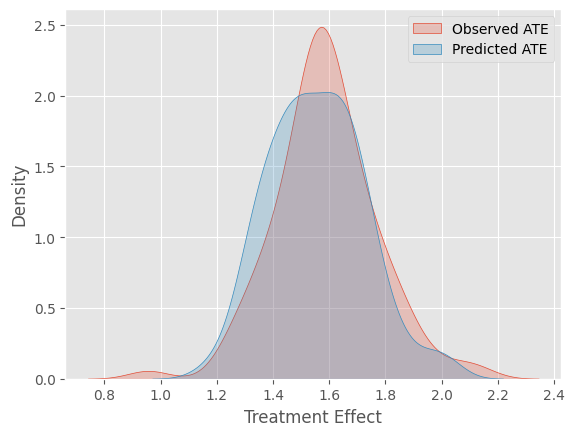

In [8]:
fig, ax = plt.subplots()
sns.kdeplot(observed_effects, label='Observed ATE', ax = ax, fill = True)
sns.kdeplot(predicted_effects, label='Predicted ATE', ax = ax, fill = True)

ax.legend()
ax.set_xlabel('Treatment Effect')

# Multi sim

In [27]:

experiment_result_df_list = list()

test_normal_params = [
    {'loc': 0, 'scale': 1},
    {'loc': 0.5, 'scale': 1},
    {'loc': 1, 'scale': 1},
    {'loc': 1.5, 'scale': 1},
    {'loc': 2, 'scale': 1},
    {'loc': 2.5, 'scale': 1},
    {'loc': 3, 'scale': 1},
    {'loc': 10, 'scale': 1},
    {'loc': 100, 'scale': 1},
]

for test_normal_param in test_normal_params:
    observed_effects = list()
    predicted_effects = list()
    for i in range(100):
        observed_effect, predicted_effect = surrogate_index_model_experiment(
            n_surrogates=4,
            train_normal_params = {'loc': 0, 'scale': 1},
            test_normal_params = test_normal_param,
            train_treatment_effect = 0.0,
            test_treatment_effect=1.0,
            decay_factor = 1.0
        )
        observed_effects.append(observed_effect)
        predicted_effects.append(predicted_effect)
        experiment_results = (
            pd.DataFrame(
                data = {
                    'observed_effect': observed_effects,
                    'predicted_effect': predicted_effects
                }
            )
            .assign(
                test_control_mean = test_normal_param['loc']
            )
        )
        experiment_result_df_list.append(experiment_results)
        

In [28]:
full_experiment_results = pd.concat(experiment_result_df_list)

In [29]:
full_experiment_results

,observed_effect,predicted_effect,test_control_mean
0,1.411055,1.513931,0.0
0,1.411055,1.513931,0.0
1,1.476896,1.323802,0.0
0,1.411055,1.513931,0.0
1,1.476896,1.323802,0.0
...,...,...,...
95,2.339024,1.894132,100.0
96,1.549000,1.470227,100.0
97,0.871610,1.772395,100.0
98,1.925045,1.917904,100.0


<Axes: xlabel='observed_effect', ylabel='predicted_effect'>

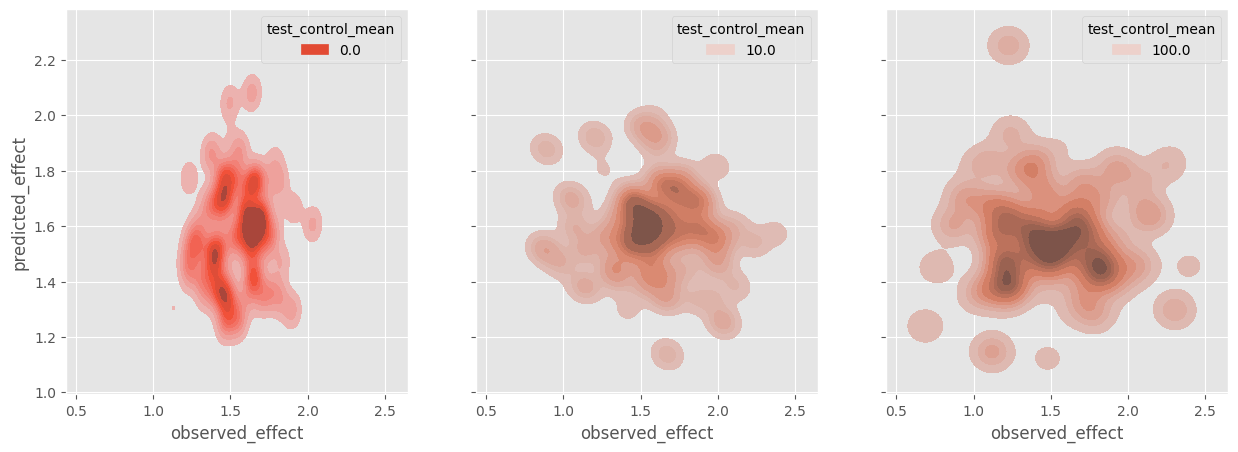

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

sns.kdeplot(data=full_experiment_results.query('test_control_mean == 0'), x='observed_effect', y='predicted_effect', hue='test_control_mean', fill=True, ax=ax[0])
sns.kdeplot(data=full_experiment_results.query('test_control_mean == 10'), x='observed_effect', y='predicted_effect', hue='test_control_mean', fill=True, ax=ax[1])
sns.kdeplot(data=full_experiment_results.query('test_control_mean == 100'), x='observed_effect', y='predicted_effect', hue='test_control_mean', fill=True, ax=ax[2])

# Multi sim (var)

In [31]:

experiment_result_df_list = list()

test_normal_params = [
    {'loc': 0, 'scale': 1},
    {'loc': 0, 'scale': 1.5},
    {'loc': 0, 'scale': 2},
    {'loc': 0, 'scale': 2.5},
    {'loc': 0, 'scale': 3},
    {'loc': 0, 'scale': 4},
    {'loc': 0, 'scale': 5},
    {'loc': 0, 'scale': 10},
    {'loc': 0, 'scale': 100},
]

for test_normal_param in test_normal_params:
    observed_effects = list()
    predicted_effects = list()
    for i in range(100):
        observed_effect, predicted_effect = surrogate_index_model_experiment(
            n_surrogates=4,
            train_normal_params = {'loc': 0, 'scale': 1},
            test_normal_params = test_normal_param,
            train_treatment_effect = 0.0,
            test_treatment_effect=1.0,
            decay_factor = 1.0
        )
        observed_effects.append(observed_effect)
        predicted_effects.append(predicted_effect)
        experiment_results = (
            pd.DataFrame(
                data = {
                    'observed_effect': observed_effects,
                    'predicted_effect': predicted_effects
                }
            )
            .assign(
                test_control_var = test_normal_param['scale']
            )
        )
        experiment_result_df_list.append(experiment_results)
        

In [32]:
full_experiment_results = pd.concat(experiment_result_df_list)

In [33]:
full_experiment_results

,observed_effect,predicted_effect,test_control_var
0,1.615576,1.554091,1.0
0,1.615576,1.554091,1.0
1,1.573888,1.688433,1.0
0,1.615576,1.554091,1.0
1,1.573888,1.688433,1.0
...,...,...,...
95,-5.204701,2.591611,100.0
96,-7.332486,7.508373,100.0
97,-38.169991,-8.690593,100.0
98,-17.874428,3.603139,100.0


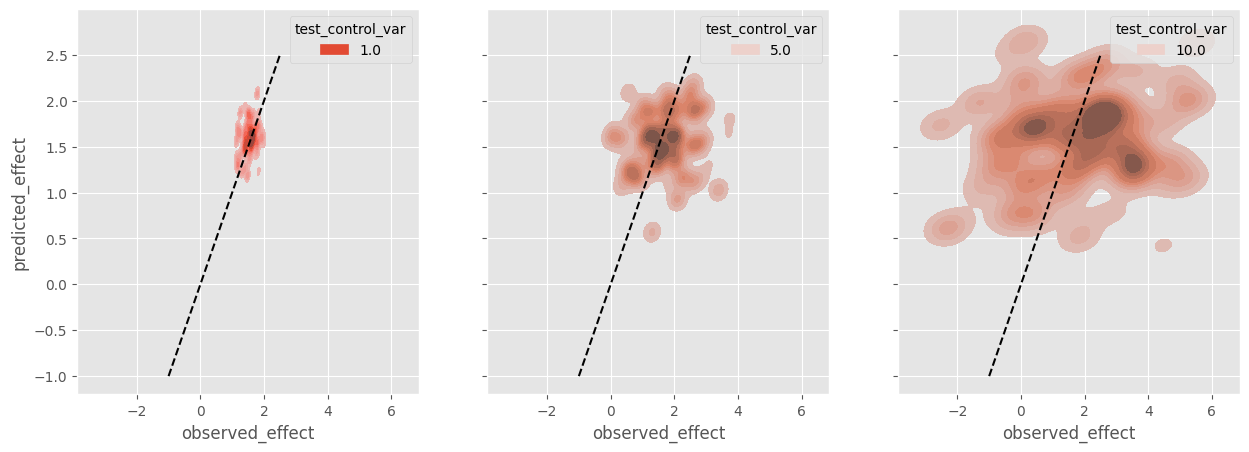

In [39]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

sns.kdeplot(data=full_experiment_results.query('test_control_var == 1'), x='observed_effect', y='predicted_effect', hue='test_control_var', fill=True, ax=ax[0])
sns.kdeplot(data=full_experiment_results.query('test_control_var == 5'), x='observed_effect', y='predicted_effect', hue='test_control_var', fill=True, ax=ax[1])
sns.kdeplot(data=full_experiment_results.query('test_control_var == 10'), x='observed_effect', y='predicted_effect', hue='test_control_var', fill=True, ax=ax[2])
for ax_i in ax:
    ax_i.plot([-1, 2.5], [-1, 2.5], color='black', linestyle='--')